In [11]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [12]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [13]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 100
    args.margin_loss = 4.0
    args.border  = 21
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args

def concatenate_mini_batches_feat_orien(batch_result):
    mini_feat_batch_concat = []
    mini_orien_batch_concat = []
    
    for i, (boxs, mini_feat_batch, mini_orien_batch) in enumerate(batch_result):
        mini_feat_batch_concat.append(mini_feat_batch)
        mini_orien_batch_concat.append(mini_orien_batch)

    mini_feat_batch_concat = torch.cat(mini_feat_batch_concat, dim=0)
    mini_orien_batch_concat = torch.cat(mini_orien_batch_concat, dim=0)

    mini_dataloader = torch.stack([mini_feat_batch_concat, mini_orien_batch_concat], dim=1)

    return mini_dataloader


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

Já foi treinado
epoca 100 loss 3.536601146062214
100 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3])


### Segementa todas as features de batch só

mini_dataloader  torch.Size([4482, 2, 31, 31])


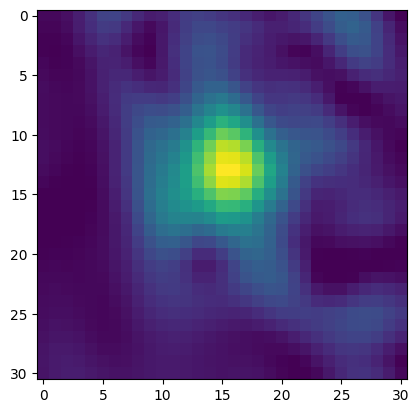

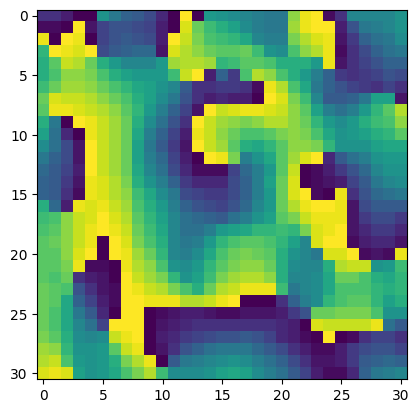

In [14]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

mini_dataloader = concatenate_mini_batches_feat_orien(batch_result)
print('mini_dataloader ',mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [15]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 25

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.6
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


108
72


### Define arquitetura do modelo de rede siamesa

In [16]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

S = args.box_size
GROUPS = 36
OUT_SHAPE = (5,5)

In [17]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn


class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
  
        r2_act = gspaces.Rot2dOnR2(N=GROUPS)
        feat_type_in = enn.FieldType(r2_act, n_channel*[r2_act.trivial_repr])
        feat_type_hid = enn.FieldType(r2_act, 8*[r2_act.regular_repr])
        feat_type_out = enn.FieldType(r2_act, 32*[r2_act.regular_repr])   
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.MaskModule(feat_type_in,S),
                enn.R2Conv(feat_type_in, feat_type_hid, kernel_size=5),
                enn.InnerBatchNorm(feat_type_hid),
                enn.ReLU(feat_type_hid),
                # enn.PointwiseMaxPool(feat_type_hid, kernel_size=3, stride=1),
                # enn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=5),
                # enn.InnerBatchNorm(feat_type_hid),
                # enn.ReLU(feat_type_hid),
                # enn.PointwiseMaxPool(feat_type_hid, kernel_size=3, stride=1),
                # enn.R2Conv(feat_type_hid, feat_type_out, kernel_size=7),
                # enn.InnerBatchNorm(feat_type_out),
                # enn.ReLU(feat_type_out),
                )
        feat_type_out = feat_type_hid
        self.pool_summary = enn.SequentialModule(                
                enn.PointwiseAdaptiveAvgPool(feat_type_out,OUT_SHAPE),#subtituir por outro adpativo PointwiseAdaptiveMaxPool
                enn.GroupPooling(feat_type_out)
                )
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        n_dim = X1.shape[-1]
        mask = enn.MaskModule(self.input_type, n_dim, margin=2).to(device)
        x = mask(x)
        x = self.block1(x)
        x = self.pool_summary(x)  
        return x
    

class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*1*8, 64)
        self.dense2 = nn.Linear(64, 2*8)
        self.droupout = nn.Dropout(0.1)
        self.activation = nn.LeakyReLU()

    
    def forward(self,X1,X2)->torch.Tensor:        
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
        # print(X1.shape,flatten_x1.shape)
        x = flatten_x1 - flatten_x2
        x = torch.cat((flatten_x1,x),dim=1)             
        x = self.droupout(self.dense1(x))
        x = self.activation(x)
        x = self.droupout(self.dense2(x))
        x = self.activation(x)
        # Calculando a distância euclidiana
        #  x = flatten_x1 - flatten_x2
        distance = torch.norm(x, dim=1,p=2)
        x = self.activation(distance)
        return x

class Siamesa(nn.Module):
    def __init__(self,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x


### Metodos para o processo de treinamento

In [18]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = args.margin_loss
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10)(x)
    return x


In [19]:
model =Siamesa(n_channel=2).to(device)
X1=torch.rand(8,2,args.box_size,args.box_size).to(device)
X2=torch.rand(8,2,args.box_size,args.box_size).to(device)
out = model.feature(X1)
sub_path = out[0,:,0:2,0:2]
print(type(sub_path),out.shape,sub_path)
# dist = model(X1,X2)
# dist

<class 'e2cnn.nn.geometric_tensor.GeometricTensor'> torch.Size([8, 8, 5, 5]) g_tensor([[[[1.7398, 0.5217],
            [0.4169, 0.3787]],
  
           [[0.5233, 0.5441],
            [0.6835, 0.4683]],
  
           [[0.5984, 0.6195],
            [0.9826, 0.6040]],
  
           [[0.5482, 0.5547],
            [0.6753, 0.6425]],
  
           [[1.1419, 0.5967],
            [0.8339, 0.4739]],
  
           [[0.2583, 0.3651],
            [0.4118, 0.4873]],
  
           [[0.4781, 0.5848],
            [0.6768, 0.5508]],
  
           [[0.2846, 0.4627],
            [0.6277, 0.7239]]]], device='cuda:0', grad_fn=<SliceBackward0>, [36-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}])


In [20]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model, train_loader, test_loader, loss_fn, epochs=10, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.75)

    best_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(epochs):
        loss_train = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        loss_test = test(model, test_loader, loss_fn, device)

        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')

        # Verificar se a perda melhorou
        if loss_test < best_loss:
            best_loss = loss_test
            epochs_without_improvement = 0
            # Salvar o estado do modelo
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1

        # Verificar a condição de parada
        if epochs_without_improvement == 50:
            print(f"No improvement in loss for {epochs_without_improvement} epochs. Training stopped.")
            break

        # Atualizar a taxa de aprendizado
        if (epoch % 10 == 0) and (epoch != 0):
            scheduler.step()

        print('initial_lr:', optimizer.param_groups[0]['initial_lr'], 'lr:', optimizer.param_groups[0]['lr'],' epochs_without_improvement ',epochs_without_improvement)

    # Carregar a melhor configuração do modelo
    model.load_state_dict(best_model)
    print(f'Epoch: {epoch}, Best Loss: {best_loss:.4f}')
    

train(model,train_loader,test_loader,loss_fn,epochs=300,device=device)

Train :   0%|          | 0/108 [00:00<?, ?it/s]


AttributeError: 'GeometricTensor' object has no attribute 'view'

In [ ]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = '.\data\models\siamese_model.pth'
# save_model(model,path_siamese)
save_model(model,path_siamese)
model = Siamesa(n_channel=2).to(device)
load_model(model,path_siamese)



Model saved to .\data\models\siamese_model.pth
Model loaded from .\data\models\siamese_model.pth


### Teste com a rede siamesa

In [ ]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [ ]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


torch.Size([25, 2, 31, 31])


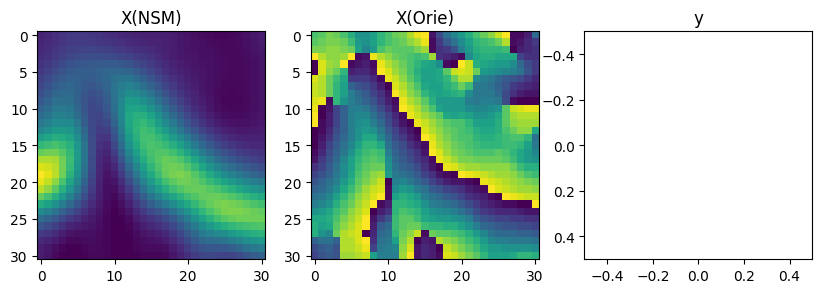

c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\torch\nn\functional.py:4332: UserWarning: Since version 1.3.0, affine_grid behavior has changed for unit-size grids when align_corners=True. This is not an intended use case of affine_grid. See the documentation of affine_grid for details.
  warnings.warn(


tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0121, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.5708, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.8199, device='cuda:0')


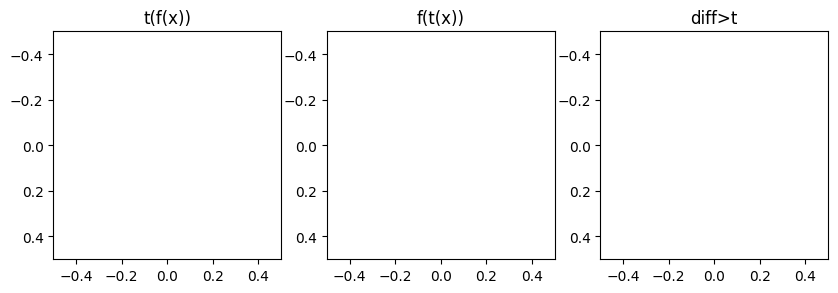

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0106, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6117, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.6464, device='cuda:0')


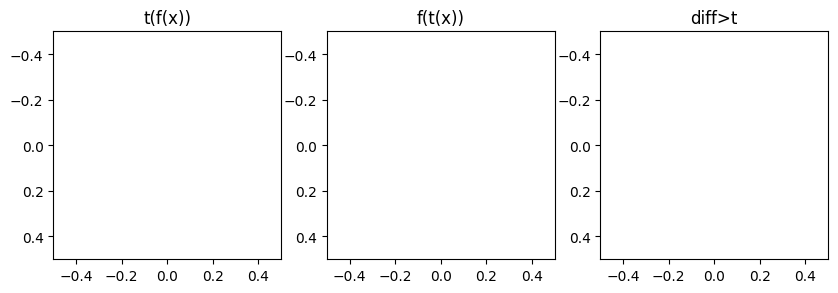

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0114, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.5545, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.0303, device='cuda:0')


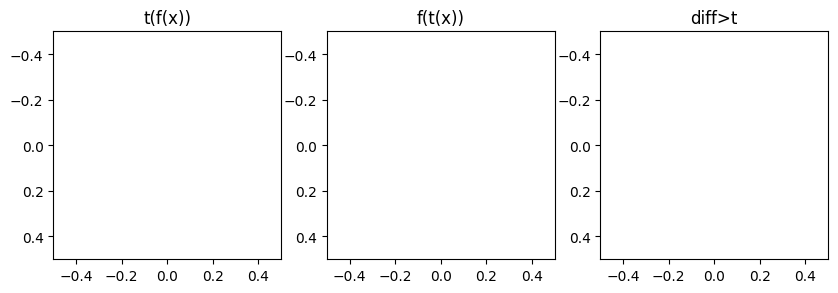

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0116, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.5718, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.8749, device='cuda:0')


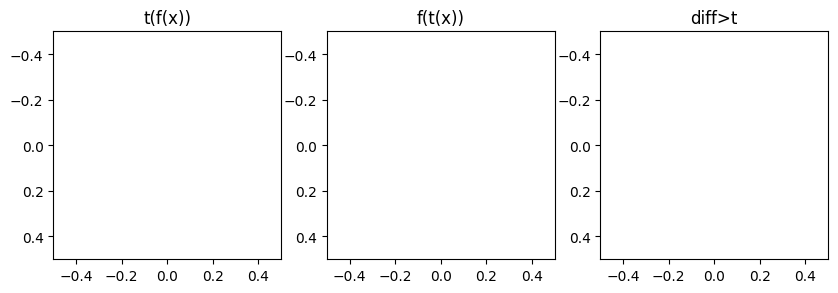

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0104, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.5990, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.5637, device='cuda:0')


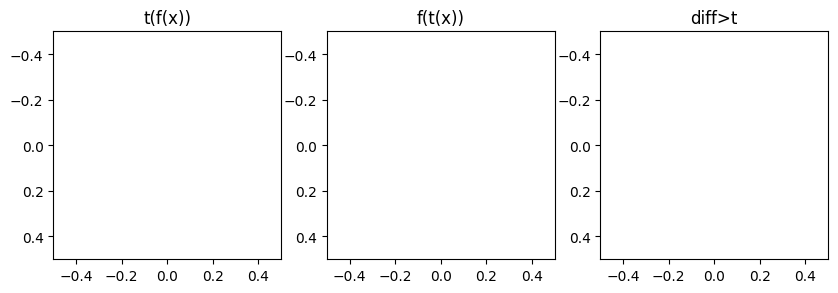

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0115, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.5773, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.9207, device='cuda:0')


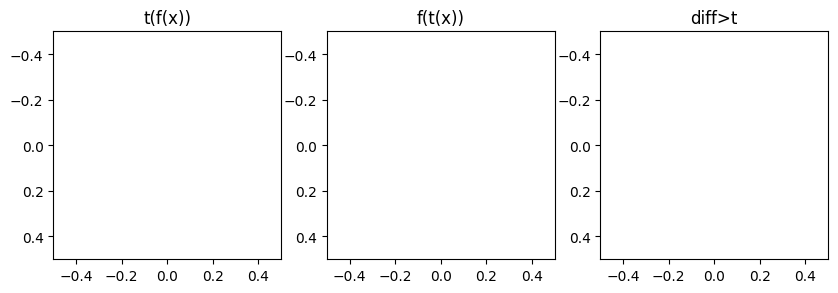

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0110, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6053, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.6938, device='cuda:0')


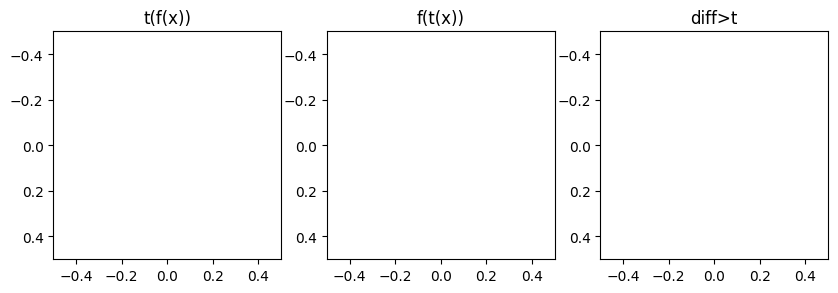

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0117, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.5742, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.7819, device='cuda:0')


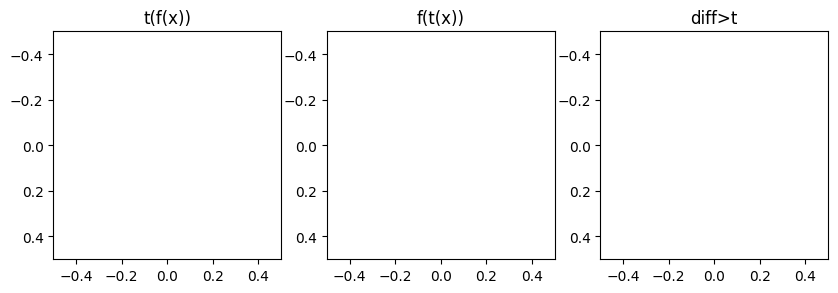

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0106, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6116, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.5938, device='cuda:0')


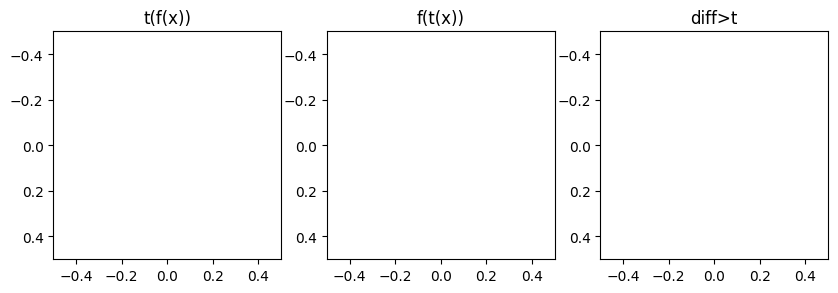

tensor(nan, device='cuda:0') tensor(0.0207, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.6016, device='cuda:0')
tensor(nan, device='cuda:0') tensor(0.0115, device='cuda:0') tensor(nan, device='cuda:0') tensor(2.5702, device='cuda:0')
tensor(nan, device='cuda:0') tensor(nan, device='cuda:0') tensor(1.7299, device='cuda:0')


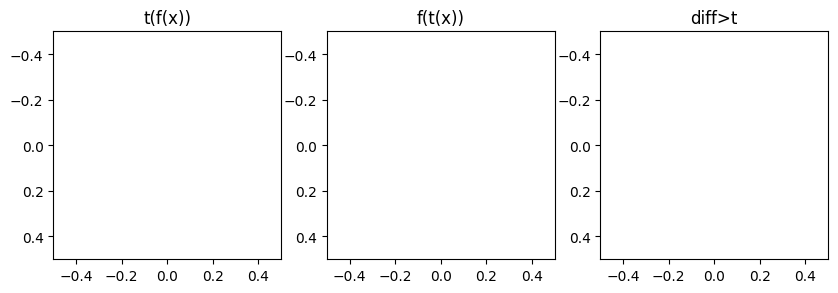

In [ ]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)


iterator=iter(test_loader)
data = next(iterator)
print(data.shape)
index = 5
with torch.no_grad():
    y = model_feature(data)
    c_mask = create_circular_mask(y.shape[2],y.shape[3])
    c_mask = torch.tensor(c_mask).to(device)

    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X(NSM)",title2="X(Orie)",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[index,0])
        y2n=normalize_tensor(y_rotated2[index,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[index])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [ ]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

def matching_single_points(data1, data2, apply_random_transform=False):
    size = len(data1)
    matches = []

    with torch.no_grad():
        for i in range(len(data2)):
            img_temp = data2[i][None]

            if apply_random_transform:
                img_temp2 = random_transform(img_temp)
            else:
                img_temp2 = img_temp.clone()

            data_temp = copy_tensor(img_temp2, size)

            distances = model(data1, data_temp)
            match_index = distances.argmin().item()
            matches.append((i, match_index))
    print(matches)
    return np.array(matches)

            

def matching_single_points_all_dataloader(test_loader, apply_random_transform=False):
    total_acertos = 0
    total =0
    for data in test_loader:
        data1 = data
        data2 = data.clone()
        size = len(data1)
        matches = []
        with torch.no_grad():
            for i in range(len(data2)):
                img_temp = data2[i][None]

                if apply_random_transform:
                    img_temp = random_transform(img_temp)


                data_temp = copy_tensor(img_temp, size)

                distances = model(data1, data_temp)
                match_index = distances.argmin().item()
                matches.append((i, match_index))
                # print(i,distances)
            print(matches)
            matches = np.array(matches)
            total_acertos += np.sum(matches[:, 0] == matches[:, 1])
            total += len(matches)
            print(total_acertos,total)
    return total_acertos,total


total_acertos,total = matching_single_points_all_dataloader(test_loader, apply_random_transform=True)
print(total_acertos,total,total_acertos/total)


# for (i,j) in matching_results[:10]:
#     print('i ',i,' j ',j)
#     plot_pair_image(data[i,0],data2[j,0],'feat_a {}'.format(i),'feat_b {}'.format(j))

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 1), (10, 4), (11, 11), (12, 12), (13, 13), (14, 4), (15, 15), (16, 16), (17, 17), (18, 18), (19, 3), (20, 20), (21, 21), (22, 22), (23, 1), (24, 24)]
20 25
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 22), (11, 11), (12, 9), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 2), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24)]
42 50
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 6), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 10), (24, 24)]
65 75
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 19), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 17), (21, 21), (22, 22), (23, 23), (24, 24)]
88 100
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 9), (5, 5), (6, 6), 

### Comparar features de duas imagens



In [ ]:
#plot pair image with tensor
def plot_pair_image(data1, data2, title1, title2):
    # vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(data1.cpu().detach())
    ax[0].set_title(title1)
    ax[1].imshow(data2.cpu().detach())
    ax[1].set_title(title2)
    plt.show()

In [ ]:
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def plot_matches_by_coord(image1, coords1, image2, coords2, matches, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt

    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]
    ax.plot(coords1[0, :], coords1[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)
    ax.plot(coords2[0, :] + offset, coords2[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)

    for i, (x, y) in enumerate(zip(coords1[0, :], coords1[1, :])):
        ax.annotate(str(i), (x, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for i, (x, y) in enumerate(zip(coords2[0, :], coords2[1, :])):
        ax.annotate(str(i), (x + offset, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for match in matches:
        x1, y1 = coords1[0, match[0]], coords1[1, match[0]]
        x2, y2 = coords2[0, match[1]] + offset, coords2[1, match[1]]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

In [ ]:
#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow2(img1,img2,coords=None,t1="0",t2="1",figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)
    ax1.title.set_text(t1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)
    ax2.title.set_text(t2)
    if coords is not None:
        ax1.plot(coords[0,:],coords[1,:], 'r+')
        ax2.plot(coords[0,:],coords[1,:], 'r+')
        # zip joins x and y coordinates in pairs
        labels = np.arange(coords.shape[1])
        for i, (x,y) in enumerate(zip(coords[0,:],coords[1,:])):
            ax1.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
            
            ax2.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
    plt.show()

100 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3])
1 tensor([0])


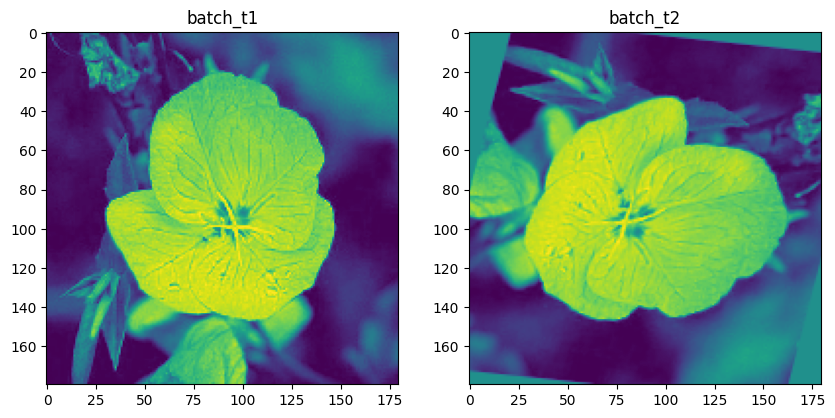

mini_dataloader  torch.Size([12, 2, 31, 31]) torch.Size([1, 3, 12])


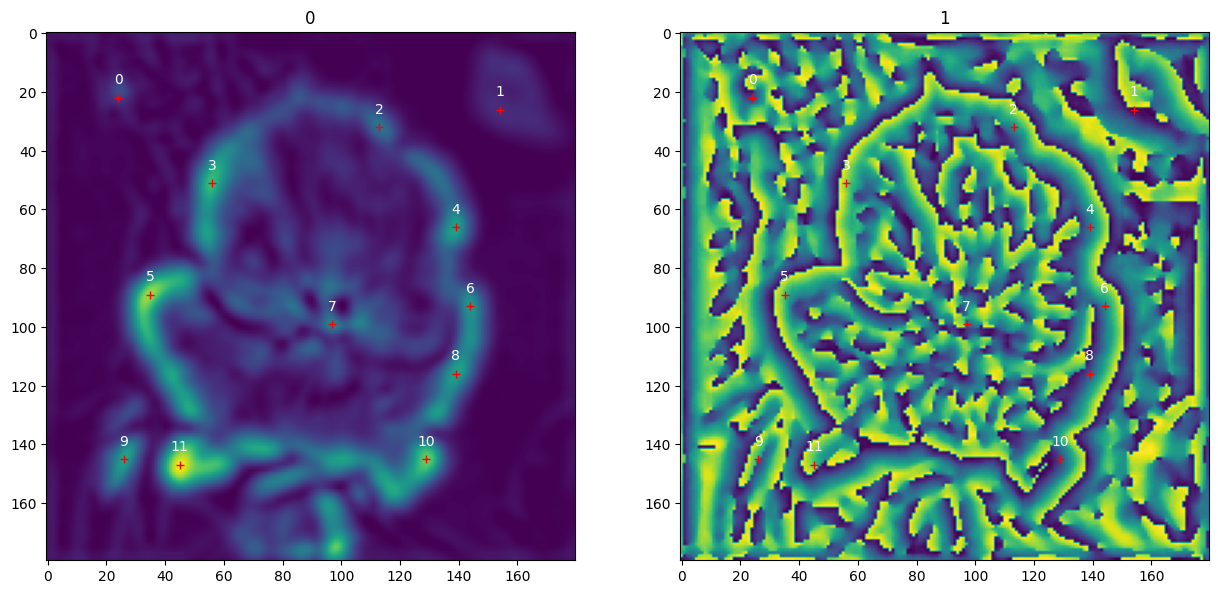

mini_dataloader  torch.Size([11, 2, 31, 31]) torch.Size([1, 11, 2])


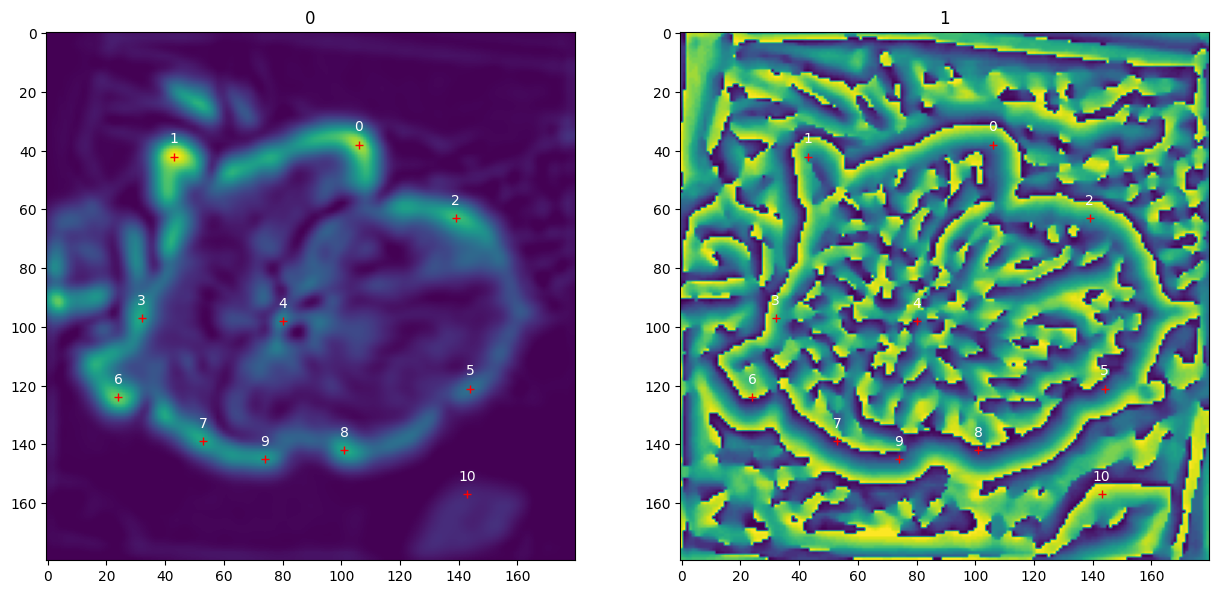

In [ ]:
args.nms_size = 30

img_batch, labels =batch
print(len(img_batch),labels) #4

batch_t1 =(img_batch[:1],labels[:1])
img_batch1, labels1 =batch_t1
print(len(img_batch1),labels1) #1

#rotaciona batch_t1
img_batch2 = random_transform(img_batch1)
batch_t2 = (img_batch2,labels1)

plot_pair_image(img_batch1[0,0],img_batch2[0,0],'batch_t1','batch_t2')

#find single point of batch_t2 and batch_t1
feature_t1,orien_t1 = predict_single_points(single_point_model,batch_t1)
batch_result_t1,coords_t1 = extract_features_with_box(feature_t1,orien_t1)
mini_dataloader_t1 = concatenate_mini_batches_feat_orien(batch_result_t1)
points_t1 = coords_t1[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t1.shape,coords_t1.shape)

imshow2(feature_t1[0,0].cpu().detach(),orien_t1[0,0].cpu().detach(),coords_t1[0,:,:17])

feature_t2,orien_t2 = predict_single_points(single_point_model,batch_t2)
batch_result_t2,coords_t2 = extract_features_with_box(feature_t2,orien_t2)
mini_dataloader_t2 = concatenate_mini_batches_feat_orien(batch_result_t2)
points_t2 = coords_t2[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t2.shape,points_t2.shape)
imshow2(feature_t2[0,0].cpu().detach(),orien_t2[0,0].cpu().detach(),coords_t2[0,:,:17])

[(0, 5), (1, 5), (2, 10), (3, 7), (4, 6), (5, 9), (6, 3), (7, 9), (8, 9), (9, 4), (10, 0)]
matching pair  [[ 0  5]
 [ 1  5]
 [ 2 10]
 [ 3  7]
 [ 4  6]
 [ 5  9]
 [ 6  3]
 [ 7  9]
 [ 8  9]
 [ 9  4]
 [10  0]]
matching pair  torch.Size([12, 2, 31, 31]) torch.Size([11, 2, 31, 31])


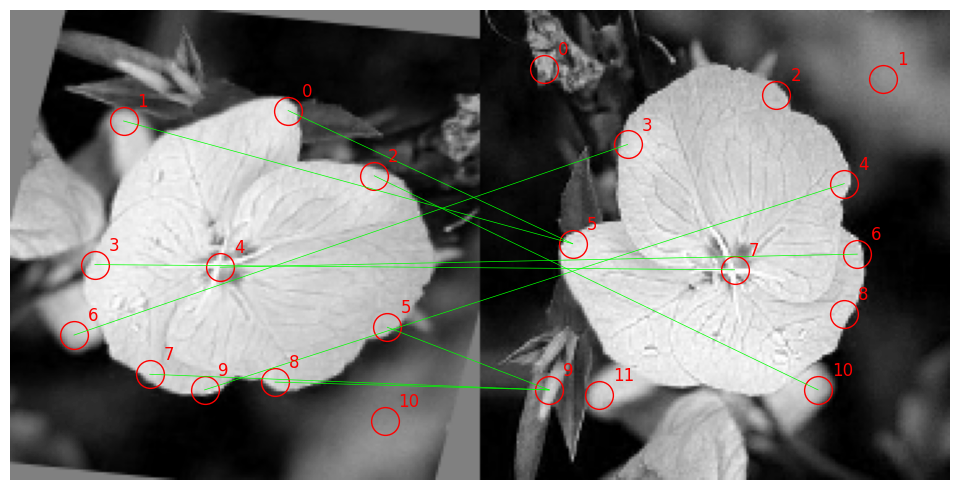

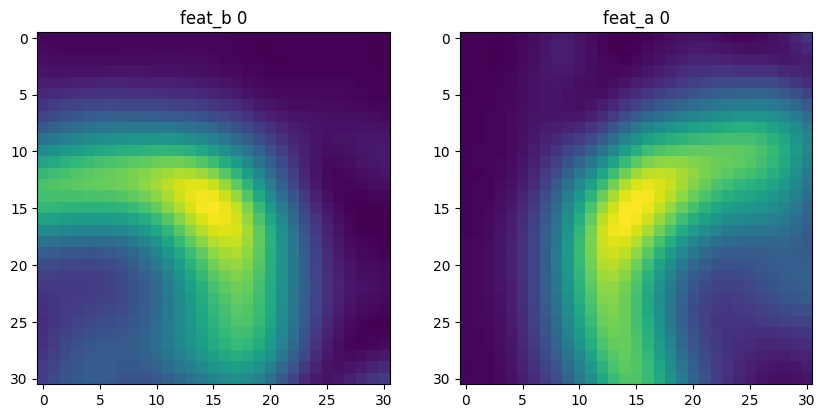

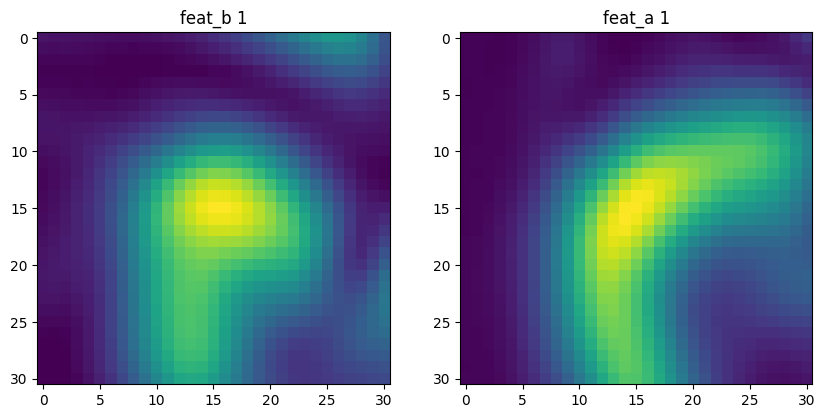

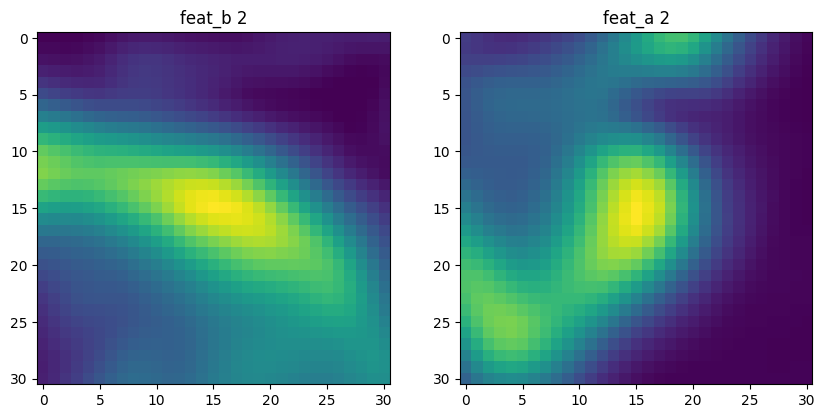

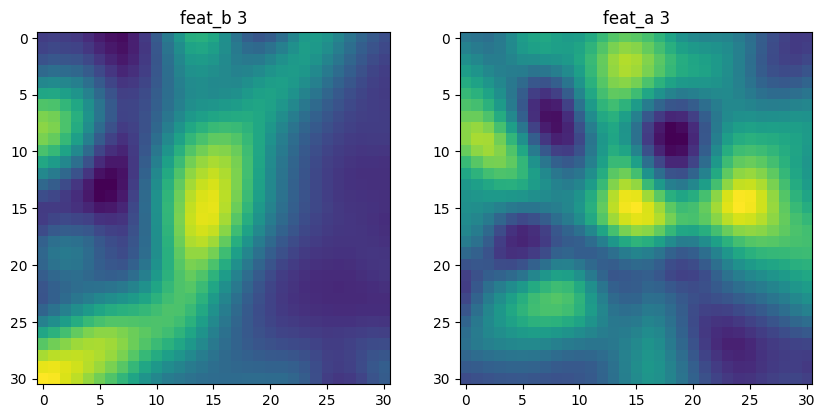

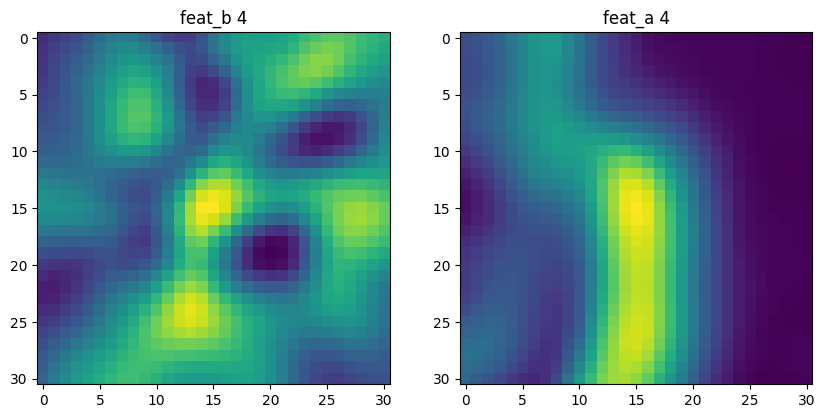

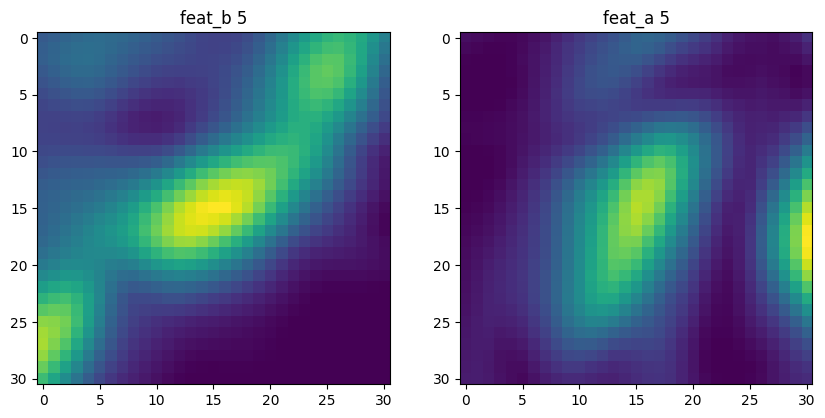

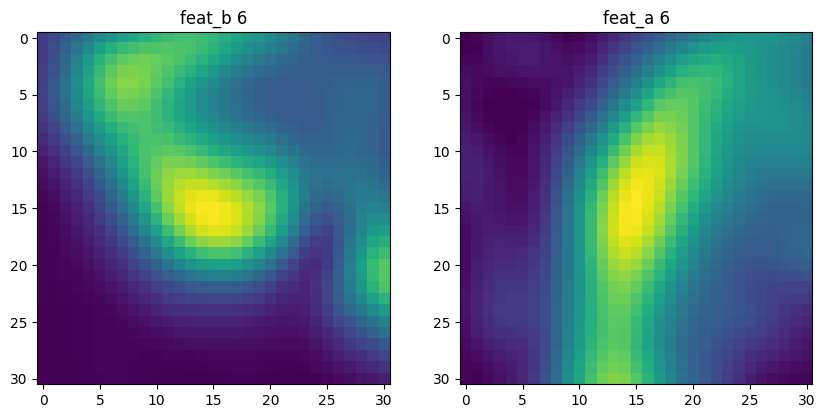

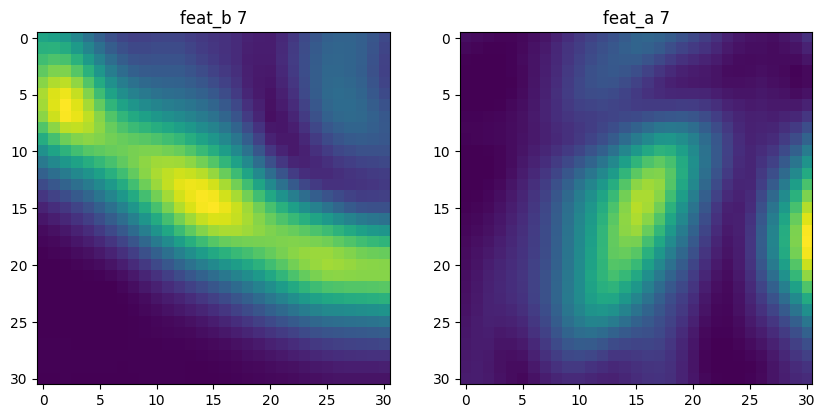

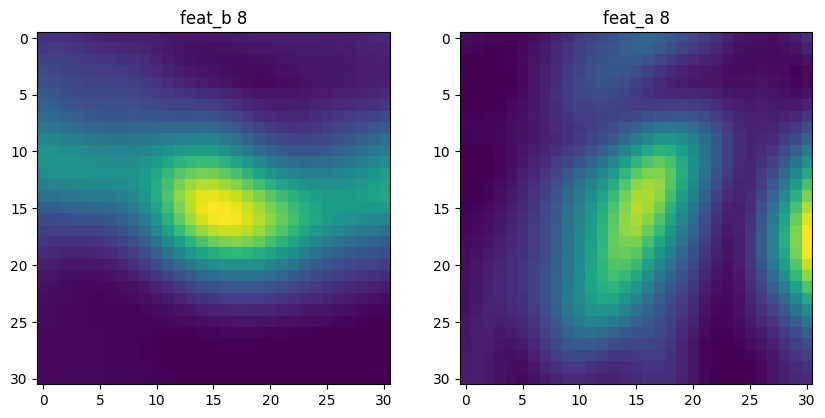

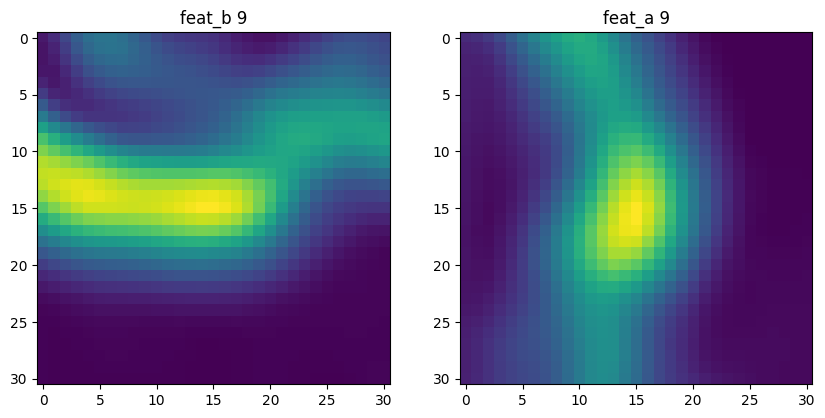

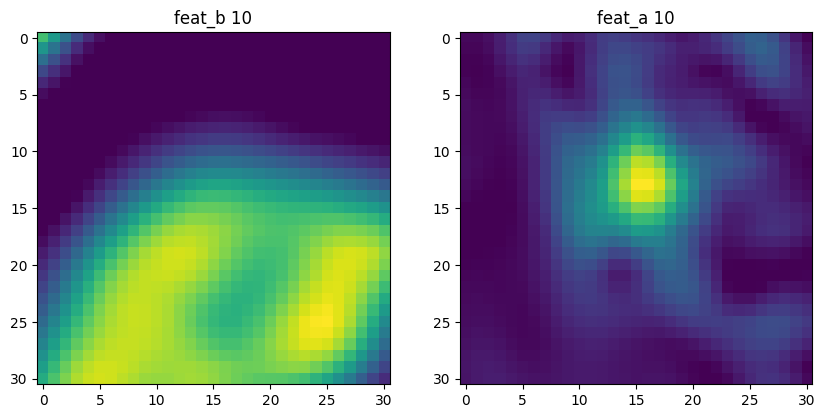

: 

In [ ]:
matching_results = matching_single_points(mini_dataloader_t1, mini_dataloader_t2,apply_random_transform=False)

print('matching pair ',matching_results)
print('matching pair ',mini_dataloader_t1.shape,mini_dataloader_t2.shape)
plot_matches_keypoints(img_batch2[0,0], points_t2[0], img_batch1[0,0], points_t1[0],matching_results[:10])
for i in range(matching_results.shape[0]):
    x,y =matching_results[i]
    plot_pair_image(mini_dataloader_t2[x,0],mini_dataloader_t1[y,0],'feat_b {}'.format(i),'feat_a {}'.format(i))

In [ ]:
import torch
import kornia.augmentation as K


# Criando uma sequência de transformações
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10),
    data_keys = ['input', 'keypoints']  # Especificando as chaves de dados
)
# Criando uma imagem de exemplo e coordenadas correspondentes
input_image = img_batch1
keypoints = torch.tensor([[[40, 50], [95, 100], [130, 130]]], dtype=torch.float32)


# Aplicando o aumento de dados nas imagens e coordenadas
augmented_image,augmented_keypoints = transformations(input_image, keypoints)

print(keypoints.shape,augmented_keypoints.shape)
print(keypoints,augmented_keypoints)
# Fazer array de matches entre arrays de coordenadas e coordenadas aumentadas
matching_results =[[i, i] for i in range(keypoints.shape[1])]


torch.Size([1, 3, 2]) torch.Size([1, 3, 2])
tensor([[[ 40.,  50.],
         [ 95., 100.],
         [130., 130.]]]) tensor([[[ 40.,  50.],
         [ 95., 100.],
         [130., 130.]]])
